In [1]:
# | default_exp diff_scratch

%load_ext autoreload
%autoreload 2

%env PYDEVD_DISABLE_FILE_VALIDATION=1

env: PYDEVD_DISABLE_FILE_VALIDATION=1


In [11]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [14]:
from datetime import datetime


class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 28x28 -> 28x28
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28 -> 14x14
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 14x14 -> 14x14
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14 -> 7x7
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),  # Fully connected layer
            nn.ReLU(),
            nn.Linear(128, 10),  # Output layer for 10 classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


# Load MNIST dataset
transform = transforms.ToTensor()
train_loader = DataLoader(
    datasets.MNIST("./data", train=True, download=True, transform=transform),
    batch_size=64,
    shuffle=True,
)
nb_batches = len(train_loader)

# Initialize model, loss, and optimizer
model = MNISTClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

nb_epochs = 3
# Train the model
model_name = "MNIST-classifier"
model_version = "0.1"
writer = SummaryWriter(
    f"../runs/{model_name}_{model_version}/{datetime.now().strftime('%m-%d-%Y_%H:%M:%S')}"
)

model.train()
with tqdm(
    total=nb_epochs * nb_batches,
    desc=f"Training update",
    unit="batch",
) as pbar:
    for epoch in range(nb_epochs):  # 2 epochs for demonstration
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            i = (epoch * nb_batches) + batch_idx
            writer.add_scalar("train loss", loss.item(), i)
            pbar.update(1)
            pbar.set_postfix(
                {
                    "epoch": epoch,
                    "batch_nb": batch_idx,
                    "train_loss": f"{loss.item():.4f}",
                }
            )

Training update: 100%|██████████| 2814/2814 [00:23<00:00, 122.34batch/s, epoch=2, batch_nb=937, train_loss=0.2466]


In [15]:
loss

tensor(0.2466, device='mps:0', grad_fn=<NllLossBackward0>)

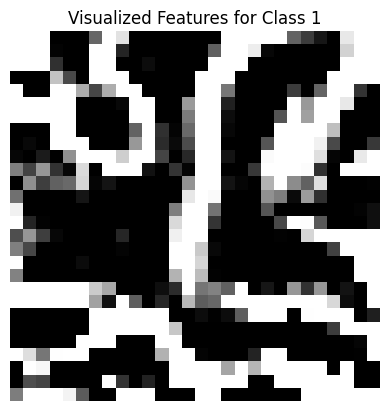

In [18]:
import matplotlib.pyplot as plt


# Function to generate an input image that maximizes a specific class
def visualize_class(model, target_class, steps=50, lr=0.1):
    model.eval()
    # Start with random noise as input
    input_image = torch.randn((1, 1, 28, 28), requires_grad=True, device=device)
    optimizer = optim.Adam([input_image], lr=lr)

    for step in range(steps):
        optimizer.zero_grad()
        output = model(input_image)
        loss = -output[0, target_class]  # Maximize activation for target_class
        loss.backward()
        optimizer.step()

        # Clamp input image to valid range
        input_image.data = input_image.data.clamp(0, 1)

    return input_image.detach().cpu().squeeze()


# Visualize the feature for class '0'
target_class = 1  # Change this to visualize other classes
generated_image = visualize_class(model, target_class)

# Plot the generated image
plt.imshow(generated_image, cmap="gray")
plt.title(f"Visualized Features for Class {target_class}")
plt.axis("off")
plt.show()